In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import re
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
import psycopg2
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from classify_campaigns import classify_campaigns

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [2]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')

In [3]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()

In [136]:
start_dt = '2021-07-19'
end_dt = '2021-08-15'
change_dt = '2021-08-01'

Drop in scale - what changed?

In [137]:
def calc_metrics(df, sov_base = 0):
    df['ctr'] = 100*df['clicks']/df['impressions']
    df['ir'] = 100*df['installs']/df['clicks']
    df['ipm'] = 1000*df['installs']/df['impressions']
    df['cpm'] = 1000*df['media_cost']/df['impressions']
    df['rpi'] = df['spend']/df['installs']
    df['margin'] = 100*(df['spend']-df['media_cost'])/df['spend']

    if sov_base == 0:
        df['media_cost_sov'] = 100*df['media_cost']/df['media_cost'].sum()
        df['spend_sov'] = 100*df['spend']/df['spend'].sum()
    else:
        df['media_cost_sov'] = 100*df['media_cost']/df.groupby(sov_base)['media_cost'].transform(sum)
        df['spend_sov'] = 100*df['spend']/df.groupby(sov_base)['spend'].transform(sum)
    return df[['impressions','clicks','ctr','installs','ir','ipm','cpm','rpi','spend','spend_sov','media_cost','media_cost_sov','margin']]

format_map = {'impressions':'{:,.0f}'
             ,'clicks':'{:,.0f}'
             ,'installs':'{:,.0f}'
             ,'spend':'${:,.0f}'
             ,'media_cost':'${:,.0f}'
             ,'rpi':'${:,.2f}'
             ,'tCPI':'${:,.2f}'
             ,'eCPI':'${:,.2f}'
             ,'cpi':'${:,.2f}'
             ,'cpm':'${:,.2f}'
             ,'ctr':'{:,.1f}%'
             ,'ir':'{:,.1f}%'
             ,'ipm':'{:,.2f}'
             ,'spend_sov':'{:,.0f}%'
             ,'auto_pilot_cpi_factor':'{:,.2f}'
             ,'diff_from_tcpi':'{:,.0f}%'
             ,'margin':'{:,.0f}%'
             ,'media_cost_sov':'{:,.0f}%'}

In [138]:
df = bigquery_client.query(f"""
select
    r.ssb_buyer_id
    , date
    , extract(date from etimestamp) as edate
    , r.ssb_campaign_uuid
    , c.name as campaign_name
    , exchange_id
    , r.imp_type as imp_type_id
    , r.ad_type
    , r.ad_size
    , sp.bundle as sponsored_bnd
    , ho.bundle as hosting_bnd
    , sp.name as sponsored_bnd_name
    , ho.name as hosting_bnd_name
    , r.ctr_model
    , r.cr_model
    , case when r.ctr_model = 'production' or r.cr_model = 'production' then 'AP' else 'ML' end as model
    , r.country
    , r.platform
    , count(case when event_type = 'clear' then 1 else NULL end)*16 as impressions
    , count(case when event_type = 'click' then 1 else NULL end)*16 as clicks
    , count(case when event_type = 'install' then 1 else NULL end)*16 as installs
    , sum(case when event_type = 'install' then revenue else 0 end)*16 as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*16/1000 as cost
    , sum(case when event_type = 'clear' then bid_price else 0 end)*16/1000 as bid
from stats.rows1 r
join metadata.campaigns c 
    on r.ssb_campaign_uuid = c.uuid
    and c.name like '%Position%'
left join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
left join metadata.apps ho
    on r.hosting_app_id = ho.app_id
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and right(r.tid,1) = '0'
group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
""").to_dataframe()
df = pd.merge(df, exchange, on = 'exchange_id')
df = pd.merge(df, imp_type, on = 'imp_type_id')
df['media_cost'] = 1.25*df['cost']
df['experience_type'] = df.apply(lambda x:classify_campaigns(x), axis = 1)
df['date_range'] = df.apply(lambda x:'pre' if pd.to_datetime(x.date) <= pd.to_datetime(change_dt) else 'post', axis = 1)

In [142]:
i = []
pivot = df.pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = ['date_range'], aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 0)
format_pivot.sort_values(i + ['date_range'], ascending = False, inplace = True)
format_pivot.style.format(format_map)

In [146]:
i = ['sponsored_bnd']
pivot = df.pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i+['date_range'], aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 'date_range')
format_pivot['total_media_cost'] = format_pivot.groupby(i)['media_cost'].transform(sum)
format_pivot.sort_values(['total_media_cost','date_range'], ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','spend_sov','media_cost_sov','margin'])

Almost completely in home weather radar. will filter for that bnd only now.

In [147]:
i = ['date']
filters = (df.sponsored_bnd == 'com.home.weather.radar')
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i+['date_range'], aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 0)
format_pivot.sort_values(i + ['date_range'], ascending = [True,False], inplace = True)
format_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','margin'])

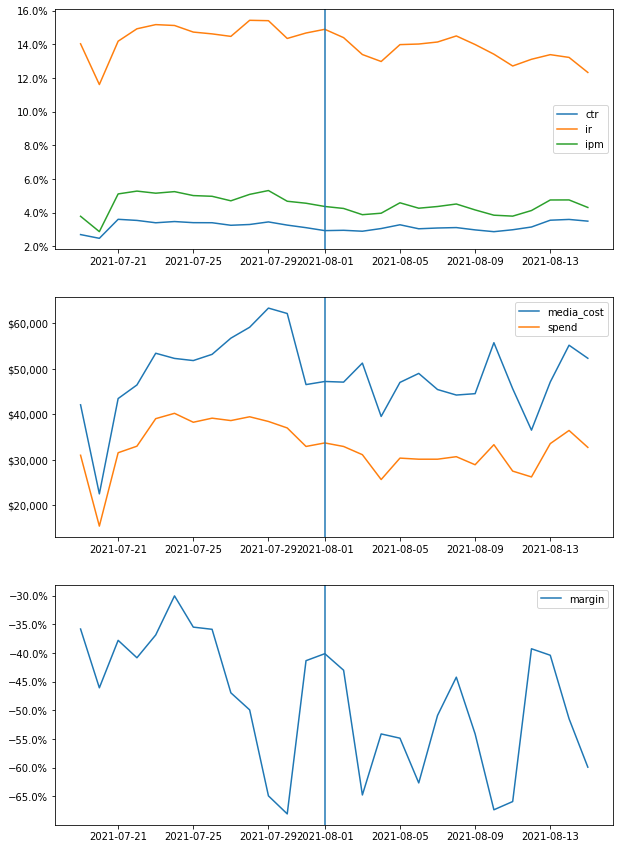

In [148]:
fig, ax = plt.subplots(3,1,figsize = (10,15))
ax[0].plot(format_pivot[['ctr','ir','ipm']].droplevel(1))
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[0].legend(['ctr','ir','ipm'])
ax[0].axvline(x = pd.to_datetime(change_dt))
ax[1].plot(format_pivot[['media_cost','spend']].droplevel(1))
ax[1].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[1].legend(['media_cost','spend'])
ax[1].axvline(x = pd.to_datetime(change_dt))
ax[2].plot(format_pivot[['margin']].droplevel(1))
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[2].axvline(x = pd.to_datetime(change_dt))
ax[2].legend(['margin'])

Looks like IR has dropped the most, from 15% to 13%

In [149]:
i = ['exchange_name']
filters = (df.sponsored_bnd == 'com.home.weather.radar')
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i+['date_range'], aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 'date_range')
format_pivot['total_media_cost'] = format_pivot.groupby(i)['media_cost'].transform(sum)
format_pivot.sort_values(['total_media_cost','date_range'], ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','spend_sov','media_cost_sov','margin'])

Fyber and InMobi see the biggest IR drop. Unity also doubled in clicks with similar installs/imps.


In [150]:
i = ['impression type','ad_type']
filters = (df.sponsored_bnd == 'com.home.weather.radar')
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i+['date_range'], aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 'date_range')
format_pivot['total_media_cost'] = format_pivot.groupby(i)['media_cost'].transform(sum)
format_pivot.sort_values(['total_media_cost','date_range'], ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','spend_sov','media_cost_sov','margin'])

Unclear, seems across multiple types.

In [151]:
i = ['exchange_name','impression type','ad_type']
filters = (df.sponsored_bnd == 'com.home.weather.radar')
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i+['date_range'], aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 'date_range')
format_pivot['total_media_cost'] = format_pivot.groupby(i)['media_cost'].transform(sum)
format_pivot.sort_values(['total_media_cost','date_range'], ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','spend_sov','media_cost_sov','margin'])

In [152]:
i = ['hosting_bnd_name']
filters = (df.sponsored_bnd == 'com.home.weather.radar')
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i+['date_range'], aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 'date_range')
format_pivot['total_media_cost'] = format_pivot.groupby(i)['media_cost'].transform(sum)
format_pivot.sort_values(['total_media_cost','date_range'], ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','spend_sov','media_cost_sov','margin'])

In [153]:
i = ['experience_type']
filters = (df.sponsored_bnd == 'com.home.weather.radar')
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i+['date_range'], aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 'date_range')
format_pivot['total_media_cost'] = format_pivot.groupby(i)['media_cost'].transform(sum)
format_pivot.sort_values(['total_media_cost','date_range'], ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','spend_sov','media_cost_sov','margin'])

In [154]:
i = ['campaign_name']
filters = (df.sponsored_bnd == 'com.home.weather.radar')
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i+['date_range'], aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 'date_range')
format_pivot['total_media_cost'] = format_pivot.groupby(i)['media_cost'].transform(sum)
format_pivot.sort_values(['total_media_cost','date_range'], ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','spend_sov','media_cost_sov','margin'])

In [155]:
i = ['model']
filters = (df.sponsored_bnd == 'com.home.weather.radar')
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i+['date_range'], aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 'date_range')
format_pivot['total_media_cost'] = format_pivot.groupby(i)['media_cost'].transform(sum)
format_pivot.sort_values(['total_media_cost','date_range'], ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','spend_sov','media_cost_sov','margin'])

Mostly ML drop

In [156]:
i = ['ctr_model']
filters = (df.sponsored_bnd == 'com.home.weather.radar')
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i+['date_range'], aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 'date_range')
format_pivot['total_media_cost'] = format_pivot.groupby(i)['media_cost'].transform(sum)
format_pivot.sort_values(['total_media_cost','date_range'], ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','spend_sov','media_cost_sov','margin'])

In [157]:
i = ['cr_model']
filters = (df.sponsored_bnd == 'com.home.weather.radar')
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i+['date_range'], aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 'date_range')
format_pivot['total_media_cost'] = format_pivot.groupby(i)['media_cost'].transform(sum)
format_pivot.sort_values(['total_media_cost','date_range'], ascending = False, inplace = True)
format_pivot.head(20).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','spend_sov','media_cost_sov','margin'])

With the accumulation in the top model - 6c03ff37a.... - a lot of the drop came from the top CR model. But about 21% of the sov of cost has come from newer models with lower IRs and higher CPMs.

In [164]:
i = ['date']
filters = (df.cr_model == '6c03ff37a3a42d39b7694148e3bd02e3_c2i') & (df.sponsored_bnd == 'com.home.weather.radar')
pivot = df[filters].pivot_table(values = ['impressions','clicks','installs','spend','media_cost'], index = i+['date_range'], aggfunc = np.sum)
format_pivot = calc_metrics(pivot, 'date_range')
format_pivot['total_media_cost'] = format_pivot.groupby(i)['media_cost'].transform(sum)
format_pivot.sort_values(['date','date_range'], ascending = True, inplace = True)
format_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','rpi','spend_sov','media_cost_sov','margin'])

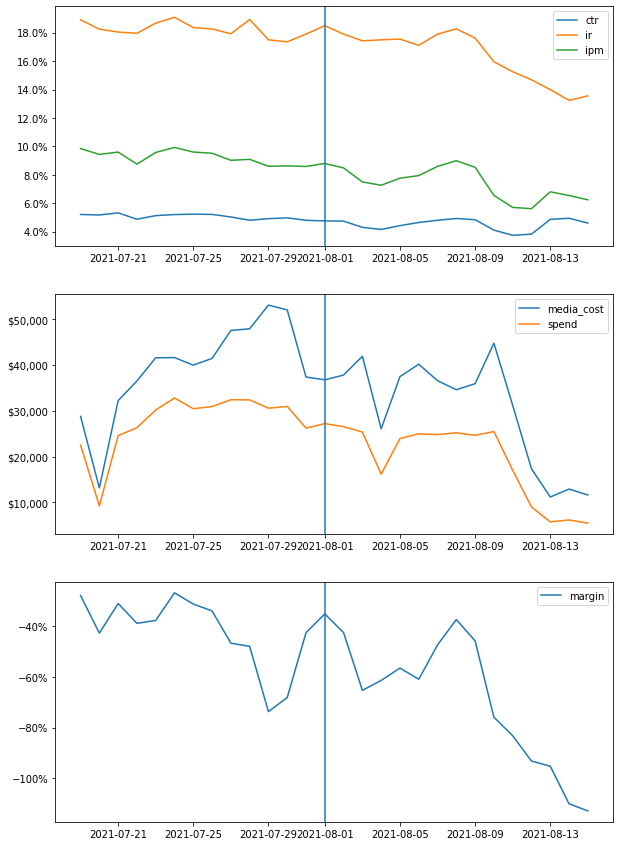

In [159]:
fig, ax = plt.subplots(3,1,figsize = (10,15))
ax[0].plot(format_pivot[['ctr','ir','ipm']].droplevel(1))
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[0].legend(['ctr','ir','ipm'])
ax[0].axvline(x = pd.to_datetime(change_dt))
ax[1].plot(format_pivot[['media_cost','spend']].droplevel(1))
ax[1].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[1].legend(['media_cost','spend'])
ax[1].axvline(x = pd.to_datetime(change_dt))
ax[2].plot(format_pivot[['margin']].droplevel(1))
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[2].axvline(x = pd.to_datetime(change_dt))
ax[2].legend(['margin'])

## check organics

In [160]:
df.sponsored_bnd.unique()

array(['com.home.weather.radar', 'com.home.news.breaking',
       'com.home.bible.verse.prayer'], dtype=object)

In [161]:
df_organics = bigquery_client.query(f"""
select
    bundle
    , type
    , event_name
    , date(t_created) as date
    , count(*)*16 as installs
from external_data.ext_data
where 
    date(t_created) >= '{start_dt}'
    and date(t_created) <= '{end_dt}'
    and type = 'install'
    and bundle in ('com.home.weather.radar')
    and right(ifa,1) = '0'
group by 1,2,3,4
""").to_dataframe()
df_organics

bundle     type event_name        date  installs
0   com.home.weather.radar  install       None  2021-07-22     49296
1   com.home.weather.radar  install       None  2021-08-12     53280
2   com.home.weather.radar  install       None  2021-08-09     54896
3   com.home.weather.radar  install       None  2021-08-14     65248
4   com.home.weather.radar  install       None  2021-07-27     56496
5   com.home.weather.radar  install       None  2021-07-25     60960
6   com.home.weather.radar  install       None  2021-08-05     50928
7   com.home.weather.radar  install       None  2021-08-04     43840
8   com.home.weather.radar  install       None  2021-08-13     58368
9   com.home.weather.radar  install       None  2021-07-31     58432
10  com.home.weather.radar  install       None  2021-08-10     57888
11  com.home.weather.radar  install       None  2021-07-28     60288
12  com.home.weather.radar  install       None  2021-07-26     66016
13  com.home.weather.radar  install       None  2021-07-20     34080
14  com.home.weather.radar  install       None  2021-07-21     56816
15  com.home.weather.radar  install       None  2021-08-06     54576
16  com.home.weather.radar  install       None  2021-07-19     54992
17  com.home.weather.radar  install       None  2021-07-29     70384
18  com.home.weather.radar  install       None  2021-07-24     60256
19  com.home.weather.radar  install       None  2021-07-23     58480
20  com.home.weather.radar  install       None  2021-07-30     59840
21  com.home.weather.radar  install       None  2021-08-15     66064
22  com.home.weather.radar  install       None  2021-08-01     62880
23  com.home.weather.radar  install       None  2021-08-07     51968
24  com.home.weather.radar  install       None  2021-08-08     54752
25  com.home.weather.radar  install       None  2021-08-11     59024
26  com.home.weather.radar  install       None  2021-08-02     55680
27  com.home.weather.radar  install       None  2021-08-03     53376

In [162]:
df_organics['date_range'] = df_organics.apply(lambda x:'pre' if x.date <= pd.to_datetime(change_dt) else 'post', axis = 1)
pivot = df_organics.pivot_table(values = ['installs','date'], index = 'date_range', columns = 'bundle', aggfunc = {'installs':sum, 'date':lambda x:len(x.unique())})
pivot.sort_index(ascending = False, inplace = True)
pivot.sort_index(axis = 1, level = [1,0], ascending = False)

installs                   date
bundle     com.home.weather.radar com.home.weather.radar
date_range                                              
pre                        809216                     14
post                       779888                     14

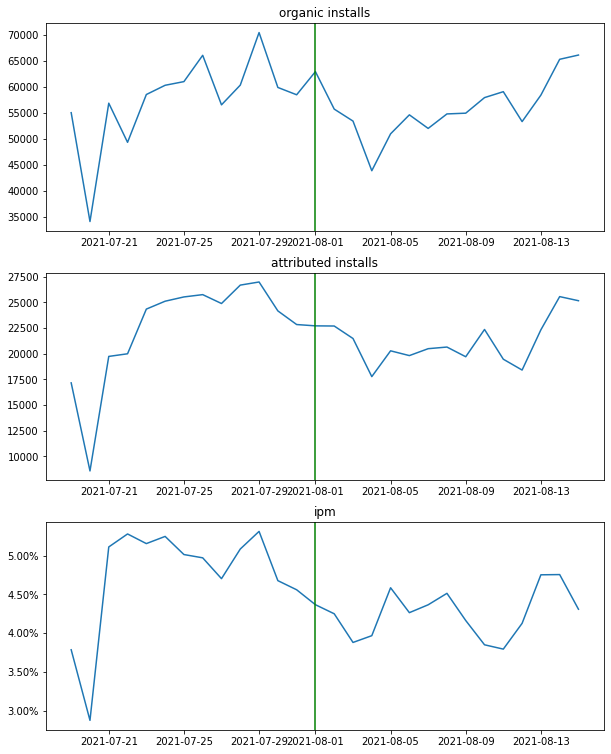

In [166]:
organic_installs = df_organics[df_organics.bundle == 'com.home.weather.radar'].pivot_table(values = 'installs', index = 'date', aggfunc = np.sum)
attr_installs = df[df.sponsored_bnd == 'com.home.weather.radar'].groupby('edate')['installs'].sum()
ir_byday = df[df.sponsored_bnd == 'com.home.weather.radar'].groupby('date')['installs','impressions'].sum()
ir_byday['ipm'] = 1000*ir_byday.installs/ir_byday.impressions

fig, ax = plt.subplots(3,1,figsize = (10,13))
ax[0].plot(organic_installs[organic_installs.index <= pd.to_datetime(end_dt)])
ax[0].set_title('organic installs')
ax[1].plot(attr_installs[attr_installs.index <= pd.to_datetime(end_dt)])
ax[1].set_title('attributed installs')
ax[2].plot(ir_byday.ipm)
ax[2].set_title('ipm')
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[0].axvline(pd.to_datetime(change_dt), color = 'green')
ax[1].axvline(pd.to_datetime(change_dt), color = 'green')
ax[2].axvline(pd.to_datetime(change_dt), color = 'green')